<a href="https://colab.research.google.com/github/gabie0208/eee4178-deep-learning/blob/main/1124_rnn_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. RNN**

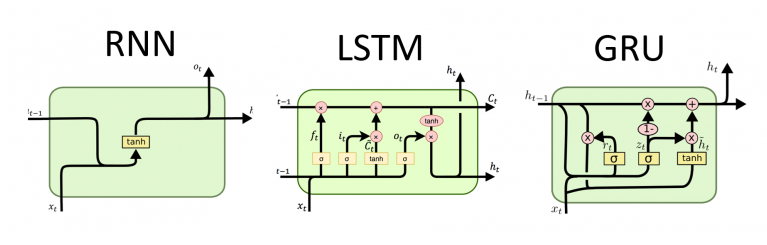

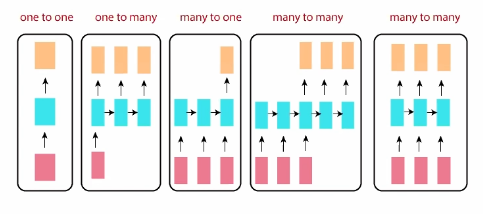

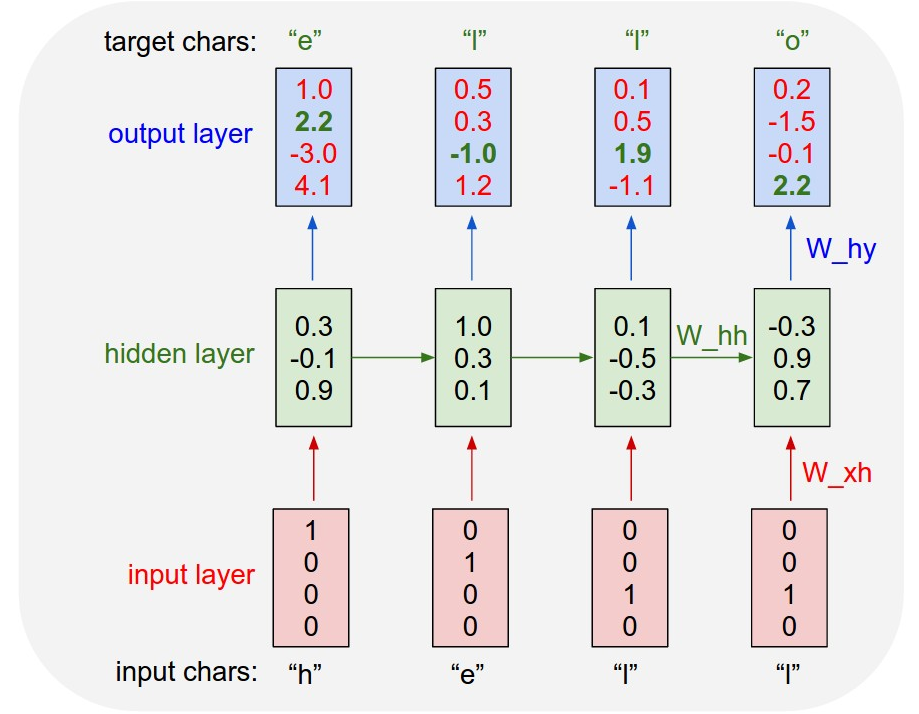

 **2.IMDB**

1. Define Hyper-parameters and Device Configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torchtext
from torchtext import data, datasets

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 64
learning_rate = 0.005
num_epochs = 5

out_node = 1 ## binary {neg, pos}
num_layers = 3
embedd_dim = 128  # 단어를 얼만큼의 차원으로 임베딩할 것인가
hidden_dim = 256  
valid_percent = 0.2  # train data를 train data, validation data 로 분리할 때의 비율 
MIN_FREQ = 10

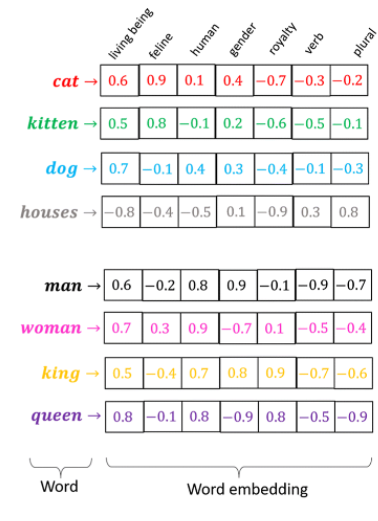

2. Load Data

2.1 Download IMDB

In [3]:
TEXT = torchtext.legacy.data.Field(sequential=True, batch_first=True, lower=True)
# TEXT = data.Field(tokenize='spacy')
LABEL = torchtext.legacy.data.LabelField(sequential=False, dtype=torch.float, batch_first=True)

train_data, test_data = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 37.6MB/s]


In [4]:
# cf) check data
print("train:", len(train_data), "test: ",len(test_data))
print(vars(train_data.examples[0]))

train: 25000 test:  25000
{'text': ['all', 'dogs', 'go', 'to', 'heaven', 'is,', 'in', 'my', 'opinion,', 'the', 'best', 'animated', 'film', 'ever', 'made.', "i'm", 'not', 'really', 'a', 'big', 'fan', 'of', 'animated', 'films,', 'but', "there's", 'something', 'about', 'this', 'one', 'that', 'makes', 'it', 'better', 'than', 'any', 'other', 'animated', 'film', "i've", 'seen.', 'the', 'music', 'is', 'wonderful', 'as', 'is', 'the', 'performances', 'of', 'burt', 'reynolds,', 'dom', 'deluise,', 'and', 'especially', 'ken', 'page', 'as', 'the', 'king', 'gator.', '"let\'s', 'make', 'music', 'together"', 'is', 'perhaps', 'one', 'of', 'my', 'favorite', 'songs', 'from', 'any', 'movie', 'musical', "i've", 'seen.', 'this', 'is', 'definitely', 'a', 'must', 'see', 'for', 'people', 'of', 'all', 'ages.'], 'label': 'pos'}


2.2 Make Validation Dataset

IMDB 데이터셋에서는 valid set을 따로 제공하지 않으므로, train data 로 부터  직접 만들어 줌

In [5]:
train_data, valid_data = train_data.split(split_ratio=1-valid_percent)

In [6]:
# cf) check each data
print("train: ", len(train_data))
print("valid: ", len(valid_data))
print("test : ", len(test_data))

train:  20000
valid:  5000
test :  25000


2.3 Build Vocabulary Set

단어 집합 생성

In [7]:
TEXT.build_vocab(train_data, min_freq=MIN_FREQ) # N번 이상 나온 단어들에 대하여 vocab set 생성
LABEL.build_vocab(train_data)

In [8]:
# cf) check Vocab Set
vocab_size = len(TEXT.vocab)
print("단어 집합의 크기: ", vocab_size)   # 해당 갯수의 단어를 가지고 분석을 진행

단어 집합의 크기:  23282


In [9]:
# cf) 가장 빈도수가 높은 20개 vocab
TEXT.vocab.itos[:20]

['<unk>',
 '<pad>',
 'the',
 'a',
 'and',
 'of',
 'to',
 'is',
 'in',
 'i',
 'this',
 'that',
 'it',
 '/><br',
 'was',
 'as',
 'for',
 'with',
 'but',
 'on']

3. Define Dataloader

In [10]:
train_loader = torchtext.legacy.data.BucketIterator(dataset=train_data,
                                  batch_size=batch_size,
                                  device=device)

valid_loader = torchtext.legacy.data.BucketIterator(dataset=valid_data,
                                  batch_size=batch_size,
                                  device=device)

test_loader = torchtext.legacy.data.BucketIterator(dataset=test_data,
                                  batch_size=batch_size,
                                  train=False,
                                  device=device)

4. Build Model

In [11]:
class Sentiment(nn.Module):
  def __init__(self, num_vocab, embedding_dim, hidden_dim, num_layers, out_node, drop_percent=0.2):
    super(Sentiment, self).__init__()

    self.num_vocab = num_vocab
    
    self.embed = nn.Embedding(num_embeddings=num_vocab, embedding_dim=embedd_dim)
    # 앞서 구성한 단어 set에 대해서, 임베딩 차원에 맞춰서 임베딩을 진행
    self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    self.dropout = nn.Dropout(drop_percent)

    self.fc = nn.Linear(hidden_dim, out_node)    

  def forward(self, x):
    x = self.embed(x)
    out, hidden = self.gru(x)
    out = self.dropout(out)
    out = self.fc(out[:,-1,:])
    return out

In [12]:
model = Sentiment(vocab_size, embedd_dim, hidden_dim, num_layers, out_node).to(device)

5. Set Loss & Optimizer

In [13]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

6. Train & Test

6.1 Train function

In [14]:
def train(model, train_loader, optimizer, criterion):
  epoch_loss, acc = 0, 0
  model.train()

  for i, data in enumerate(train_loader):
    text = data.text
    label = data.label

    out = model(text).squeeze(1)    # out의 크기가 [batch size, 1]이므로 squeeze해서 [batch size]로 size를 변경해줘야 함 
    loss = criterion(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc += (torch.round(torch.sigmoid(out))==label).sum()
    # 모델의 예측 값과 라벨이 같으면 accuracy를 증가
    epoch_loss += loss.item()
    

  return epoch_loss/(i+1), acc / len(train_loader.dataset) * 100

6.2 Evaluation function

In [15]:
def evaluate(model, data_loader, criterion):
  epoch_loss, acc = 0, 0
  model.eval()

  with torch.no_grad():
    for data in data_loader:
      text = data.text
      label = data.label

      out = model(text).squeeze(1)
      loss = criterion(out, label)

      acc += (torch.round(torch.sigmoid(out))==label).sum()
      epoch_loss += loss.item()

  return epoch_loss/len(data_loader), acc / len(data_loader.dataset) * 100

6.3 Train

In [16]:
# GRU #
# Train
print("____GRU____")
best_valid_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion)


  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch
    torch.save(model.state_dict(), "GRU_epoch_{}.pth".format(epoch))

  print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}, Valid Loss:{:.4f}, Valid Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

# Test
model.load_state_dict(torch.load('./GRU_epoch_{}.pth'.format(best_epoch)))
GRU_loss, GRU_acc = evaluate(model, test_loader, criterion)
print("\nGRU's IMDB Accuracy:{:.2f}% (Loss:{:.4f})".format(GRU_acc, GRU_loss))

____GRU____
Epoch[1/5], Train Loss:0.7132, Train Acc:50.58, Valid Loss:0.6860, Valid Acc:55.50
Epoch[2/5], Train Loss:0.5407, Train Acc:71.55, Valid Loss:0.3877, Valid Acc:83.08
Epoch[3/5], Train Loss:0.3004, Train Acc:88.10, Valid Loss:0.3556, Valid Acc:85.62
Epoch[4/5], Train Loss:0.2374, Train Acc:90.90, Valid Loss:0.3730, Valid Acc:84.56
Epoch[5/5], Train Loss:0.3413, Train Acc:85.50, Valid Loss:0.4700, Valid Acc:79.28

GRU's IMDB Accuracy:85.16% (Loss:0.3997)
